# Fund Return Analysis - Dynamic
*A template for analysing fund returns.*

-----------------------
*Author - Andrea Chello*


### Introduction:
This is a template for the analysis of Fund returns. Simply import the CSV/Excel file with the return or backtested return data into the appropriate cells and the program will analyse the data and produce the key risk/return characteristics as well as the associated graphs.

CSV/Excel file: has to be formatted as follows:
- *Date, Fund, Benchmark 1, Benchmark 2, ..., Benchmark N*


**Contents**
1. Functions
2. Import Return Data
3. Return Calculations
4. Return Characteristics
5. Risk Characteristics
6. Comparison to Benchmarks
7. Capture Information
8. Overview & Graphs

#### Import Libraries

Import the Python libraries needed to run the program.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as date
%matplotlib inline
import datetime
import math as m
import statistics as s
import scipy.stats as sp

# 1. Functions
Listed below are a set of user-defined functions created for the sole purpose
of this program. They are frequently used throughout.

In [6]:
def dataFrameMerger(lst, function, string, df2 = 0, comparison = False):
    
    """
    ==============
    Documentation: 
    
    Function that given a list of data, a function and a string that functions as
    a column index for each element, returns a merged DataFrame of all the elements 
    of each data set with the applied function.
    
    If a second dataframe is specified it merges the newly created dataframe with 
    the additional one provided.
    
    if comparison is True:
    we are comparing the fund with different benchmarks instead of simply merging each
    element as we did before.
    
    """
    
    if comparison == True:
        #get initial merge table
        
        pegged_element = lst[lst.index(fund)]
        merged = pd.merge(pd.DataFrame(function(lst)[0],index,[string + str(pegged_element) + " - " + str(lst[1])]),
                       pd.DataFrame(function(lst)[1],index, [string + str(pegged_element) + " - " + str(lst[2])]),
                       how="inner", on="Date")

        #loop to add n series/dataframes to the initial merged dataframe
        for i in range(2, len(lst)-1):
            merged = pd.merge(pd.DataFrame(merged),
                           pd.DataFrame(function(lst)[i],index,[string + str(pegged_element) + " - " + str(lst[i + 1])]),
                           how="inner", on="Date")
        
    else:
        #get initial merge table
        merged = pd.merge(pd.DataFrame(function(lst[0]),index,[string + str(lst[0])]),
                       pd.DataFrame(function(lst[1]),index, [string + str(lst[1])]),
                       how="inner", on="Date")

        #loop to add n series/dataframes to the initial merged dataframe
        for i in lst[2:]:
            merged = pd.merge(pd.DataFrame(merged),
                           pd.DataFrame(function(i),index,[string + str(i)]),
                           how="inner", on="Date")
        
    if type(df2) == type(merged):

        merged = pd.merge(merged,df2,
                   how="inner", on="Date")
        
    return merged


## 2. Import Return Data

Import the returns of the target fund and its benchmarks, either by passing through an Excel Spreadsheet or a CSV file into the corresponding DataFrame.

In [7]:
"""===================="""
"""Import from CSV File"""
"""===================="""

data = pd.read_csv("Data.csv", index_col=0, parse_dates = True)
returns_data = pd.DataFrame(data).fillna(value = 0)

lst = []
fund = returns_data.columns[0]
for i in returns_data.columns:
    lst.append(i)
benchmark_lst = [i for i in lst if i != fund]

#Grab the index
index = returns_data.index
returns_data.head()

,Invesco Global Water ETF,MSCI ACWI,MSCI EAFE,SP500
Date,,,,
2011-01-01,0.009091,0.0290,0.0174,0.00814
2011-01-02,0.022522,0.0069,0.0179,0.02753
2011-01-03,0.046500,0.0138,0.0052,-0.00342
2011-01-04,-0.021515,0.0012,0.0111,0.03859
2011-01-05,-0.031549,0.0180,0.0337,-0.02522


## 3. Return Calculations

The return characteristics serve as inputs to the risk-return metrics calculated in the final output table.

## Cumulative Performance

Calculate the cumulative return of:
- Fund
- Indices

$i_{i} = (1+r_{t})*i_{t-1}$

In [8]:
"""=================================="""
"""Cumulative Performance Fund"""
"""=================================="""

def cumulativePerformanceCalculation(dataset):
    
    #Initialize the Cumulative Performance Array
    cum_perf = []

    #Append to array first set of starting return
    count = round(1 + returns_data[dataset][0],3)
    cum_perf.append(count)

    #For loop to add the return data to the array

    for i in range(1,len(returns_data[dataset])):
        cf = round(cum_perf[i-1]*(1+returns_data[dataset][i]),3)
        cum_perf.append(cf)

    #Convert cumultative return of the fund to a NumPy array

    #Limit the data points of the array to be equal to the length of the fund returns

    cum_ret = np.array(cum_perf[:len(returns_data[dataset])])

    #Reshape the array to make it more readable
    cum_ret = cum_ret.reshape(len(returns_data[dataset]),1)
    
    return cum_ret

cumulative_performance = dataFrameMerger(lst, cumulativePerformanceCalculation,\
                                         "Cumulative Return ")
cumulative_performance.head()


,Cumulative Return Invesco Global Water ETF,Cumulative Return MSCI ACWI,Cumulative Return MSCI EAFE,Cumulative Return SP500
Date,,,,
2011-01-01,1.009,1.029,1.017,1.008
2011-01-02,1.032,1.036,1.035,1.036
2011-01-03,1.080,1.050,1.040,1.032
2011-01-04,1.057,1.051,1.052,1.072
2011-01-05,1.024,1.070,1.087,1.045


## Maximum Drawdown

Calculate the maximum drawdown of:
- Fund
- Indices

$MDD = \frac{High - Low}{Low}$

In [9]:
"""=================================="""
"""Maximum Drawdown Calculations Fund"""
"""=================================="""

def maximumDrawdownCalculation(data):
    #Initialize the MDD list
    mdd = []

    #Populate list with first element
    first = cumulative_performance["Cumulative Return " + str(data)][0]\
    /(cumulative_performance["Cumulative Return " + str(data)].iloc[0]) - 1
    mdd.append(first)

    #Loop to append the MDD formula for each element in the DataFrame
    i=0
    for i in range(1,len(returns_data[fund])):
        maxdraw = round(cumulative_performance["Cumulative Return " + str(data)][i]\
                             /(max(cumulative_performance["Cumulative Return " + str(data)]\
                                   .iloc[0:i]))- 1,3)
        mdd.append(maxdraw)
        i+=1

    #Convert to array and reshape    
    mdd = np.array(mdd).reshape(len(mdd),1)
    return mdd
    
cpf_mdd = dataFrameMerger(lst, maximumDrawdownCalculation, "Maximum Drawdown ",
                          df2 = cumulative_performance)    
cpf_mdd.head()   


,Maximum Drawdown Invesco Global Water ETF,Maximum Drawdown MSCI ACWI,Maximum Drawdown MSCI EAFE,Maximum Drawdown SP500,Cumulative Return Invesco Global Water ETF,Cumulative Return MSCI ACWI,Cumulative Return MSCI EAFE,Cumulative Return SP500
Date,,,,,,,,
2011-01-01,0.000,0.000,0.000,0.000,1.009,1.029,1.017,1.008
2011-01-02,0.023,0.007,0.018,0.028,1.032,1.036,1.035,1.036
2011-01-03,0.047,0.014,0.005,-0.004,1.080,1.050,1.040,1.032
2011-01-04,-0.021,0.001,0.012,0.035,1.057,1.051,1.052,1.072
2011-01-05,-0.052,0.018,0.033,-0.025,1.024,1.070,1.087,1.045


## Sortino Ratio

Calculate the Sortino Ratio of:
- Fund
- Indices

$Sortino\ Ratio = \frac{R_{p} - R_{f}}{\sigma_{d}}$

In [10]:
"""==============================="""
"""Sortino Ratio Calculations Fund"""
"""==============================="""

def sortinoRatioCalculation(data):
    sr = []
    for i in range(0, len(returns_data[data])):
        #Downside deviation condition - Get only negative returns (for each return)
        if returns_data[data][i] < 0:
            sr.append(returns_data[data][i])
        else:
            sr.append(0)
    #convert to numpy array
    sortino_ratio_calc = np.array(sr)
    return sortino_ratio_calc

## Cumulative Return Difference

Calculate the cumulative return difference of:
- Fund
- Indices

In [11]:
"""=============================================="""
"""Cumulative Return Difference Fund - Benchmarks"""
"""=============================================="""

def cumulativeReturnDifference(lst):
    dff = []
    pegged_element = lst[lst.index(fund)]
    for i in lst[1:]:
        diff = returns_data[pegged_element] - returns_data[i]
        dff.append(diff)

    cum_ret_diff = np.array(dff)
    return cum_ret_diff

### Merge DataFrames 

In [12]:
"""Merge dataframe versions of fund and benchmark cumulative performance
to the cumulative performance and max drawdown dataframes"""

return_calculations = dataFrameMerger(lst, function = cumulativeReturnDifference,
                                      string = "Cumulative Return Difference ",
                                      comparison = True, df2 = cpf_mdd)
return_calculations.head()


,Cumulative Return Difference Invesco Global Water ETF - MSCI ACWI,Cumulative Return Difference Invesco Global Water ETF - MSCI EAFE,Cumulative Return Difference Invesco Global Water ETF - SP500,Maximum Drawdown Invesco Global Water ETF,Maximum Drawdown MSCI ACWI,Maximum Drawdown MSCI EAFE,Maximum Drawdown SP500,Cumulative Return Invesco Global Water ETF,Cumulative Return MSCI ACWI,Cumulative Return MSCI EAFE,Cumulative Return SP500
Date,,,,,,,,,,,
2011-01-01,-0.019909,-0.008309,0.000951,0.000,0.000,0.000,0.000,1.009,1.029,1.017,1.008
2011-01-02,0.015622,0.004622,-0.005008,0.023,0.007,0.018,0.028,1.032,1.036,1.035,1.036
2011-01-03,0.032700,0.041300,0.049920,0.047,0.014,0.005,-0.004,1.080,1.050,1.040,1.032
2011-01-04,-0.022715,-0.032615,-0.060105,-0.021,0.001,0.012,0.035,1.057,1.051,1.052,1.072
2011-01-05,-0.049549,-0.065249,-0.006329,-0.052,0.018,0.033,-0.025,1.024,1.070,1.087,1.045


# 4. Return Characteristics

In [13]:
#Initialize list with the return characteristics with initial whitespaces 
#to separate table sections

ret_char_list = []
#Spaces for table data
ret_char_list += ["" for i in range(0, len(lst))]

## Cumulative Return

$Cumulative Return = \prod(1+r_{i}) - 1$

In [14]:
"""=================="""
"""Cumulative Returns"""
"""=================="""

def cumulativeReturn(data):
    #calculate cumulative return using as inputs the monthly returns
    cum_return = round(np.product(1+returns_data[data]) - 1, 3)
    return cum_return

ret_char_list += [cumulativeReturn(i) for i in lst]

## Annualised Return

$Annualised Return = (1+Cumulative Return)^{(12 / N)} - 1$

In [15]:
"""================="""
"""Annualised Return"""
"""================="""

def annualisedReturn(data):
    annualised_return = round(m.pow(1+cumulativeReturn(data),\
                                    (12/(len(returns_data[data]))))-1,3)
    return annualised_return

ret_char_list += [annualisedReturn(i) for i in lst]

## Best Month

In [16]:
"""=========="""
"""Best Month"""
"""=========="""

def bestMonth(data):
    #get the maximum monthly return value out of all the monthly return values
    best_month = round(max(returns_data[data]), 3)
    return best_month
    
ret_char_list += [bestMonth(i) for i in lst]

## Worst Month

In [17]:
"""================"""
"""Worst Month Fund"""
"""================"""
def worstMonth(data):
    #get the minimum monthly return value out of all the monthly return values
    worst_month = round(min(returns_data[data]), 3)
    return worst_month
    
ret_char_list += [worstMonth(i) for i in lst]

## Percentage of Positive Months

In [18]:
"""============================="""
"""Percentage of Positive Months"""
"""============================="""

def positiveMonths(data):
    #count how many months had positive returns
    pos_month = returns_data[data][returns_data[data]>0].count()
    #divide the number of positive months by the total number of months
    perc_pos = round(pos_month/len(returns_data[data]),3)
    return perc_pos

ret_char_list += [positiveMonths(i) for i in lst]

## Percentage of Negative Months

In [19]:
"""============================="""
"""Percentage of Positive Months"""
"""============================="""

def negativeMonths(data):
    #count how many months had negative returns
    neg_month = returns_data[data][returns_data[data]<0].count()
    #divide the number of negative months by the total number of months
    perc_neg = round(neg_month/len(returns_data[data]),3)
    return perc_neg

ret_char_list += [negativeMonths(i) for i in lst]

#Append spaces for each variable
ret_char_list += ["" for i in range(0, len(lst))]

## Merge Data

In [20]:
#Reshape Array 
ret_char_array = np.array(ret_char_list).reshape(len(ret_char_list)//len(lst),len(lst))

In [21]:
# DataFrames contain data, rows, columns
return_characteristics = pd.DataFrame(ret_char_array,["RETURN CHARACTERISTICS",
                                        "Cumulative Return",
                                        "Annualised Return",
                                        "Best Month",
                                        "Worst Month",
                                        "Percentage Positive Months", 
                                        "Percentage Negative Months",
                                        ""], 
                                        lst)

return_characteristics

,Invesco Global Water ETF,MSCI ACWI,MSCI EAFE,SP500
RETURN CHARACTERISTICS,,,,
Cumulative Return,0.439,0.302,0.14,0.384
Annualised Return,0.046,0.033,0.016,0.041
Best Month,0.098,0.029,0.035,0.107
Worst Month,-0.114,-0.032,-0.043,-0.097
Percentage Positive Months,0.588,0.649,0.526,0.598
Percentage Negative Months,0.392,0.34,0.454,0.392
,,,,


## 5. Risk Characteristics

In [22]:
#Risk-Free Rate Assumption
rf = 0.03
risk_list = []
risk_list += ["" for i in range(0, len(lst))]

## Volatility

$\sigma  = \frac{\Sigma(X - \overline{X})^2}{n}$

In [23]:
"""==============="""
"""Volatility Fund"""
"""==============="""

def volatility(data):
    #annualised volatility
    vol = round(m.sqrt(12)*s.stdev(returns_data[data]),3)
    return vol

risk_list += [volatility(i) for i in lst]

## Sharpe Ratio

$ Sharpe\ Ratio= \frac{R_{p} - R_{f}}{\sigma_{p}}$

In [24]:
"""================="""
"""Sharpe Ratio Fund"""
"""================="""

def sharpeRatio(data):
    sharpe = round((float(return_characteristics[data]["Annualised Return"]) - rf) \
                    / volatility(data),3)
    return sharpe

risk_list += [sharpeRatio(i) for i in lst]

## Sortino Ratio

$Sortino\ Ratio = \frac{R_{p} - R_{f}}{\sigma_{d}}$

In [25]:
"""=================="""
"""Sortino Ratio Fund"""
"""=================="""

def downsideDeviation(data):
    #Downside Deviation
    dst = round(s.stdev(sortinoRatioCalculation(data))*m.sqrt(12),3)
    return dst

def sortinoRatio(data):
    #Sortino
    sortino = round((float(return_characteristics[data]["Annualised Return"]) - rf) \
                         / downsideDeviation(data), 3)
    return sortino

risk_list += [sortinoRatio(i) for i in lst]

## Max Drawdown

In [26]:
"""====================="""
"""Maximum Drawdown Fund"""
"""====================="""

def maximum_drawdown(data):

    max_drawdown = round(min(return_calculations["Maximum Drawdown " + str(data)]), 3)
    return max_drawdown
        
risk_list += [maximum_drawdown(i) for i in lst]

### Merge Table

In [27]:
#Append Downside deviations and risk-free rates for each fund/benchmark

risk_list += [downsideDeviation(i) for i in lst]
risk_list += [rf for i in range(0, len(lst))]    
risk_list += ["" for i in range(0, len(lst))]

In [28]:
#Reshape the array
risk_array = np.array(risk_list).reshape(len(risk_list)//len(lst),len(lst))

In [29]:
#Merge all the risk characteristics
risk_characteristics = pd.DataFrame(risk_array,
                                   ["RISK CHARACTERISTICS",
                                   "Volatility", 
                                   "Sharpe Ratio", 
                                   "Sortino Ratio",
                                   "Maximum Drawdown",
                                   "Downside Deviation",
                                   "Risk-Free Rate",
                                   ""],
                                   lst)

risk_characteristics

,Invesco Global Water ETF,MSCI ACWI,MSCI EAFE,SP500
RISK CHARACTERISTICS,,,,
Volatility,0.147,0.039,0.045,0.121
Sharpe Ratio,0.109,0.077,-0.311,0.091
Sortino Ratio,0.19,0.136,-0.538,0.147
Maximum Drawdown,-0.265,-0.069,-0.082,-0.214
Downside Deviation,0.084,0.022,0.026,0.075
Risk-Free Rate,0.03,0.03,0.03,0.03
,,,,


## 6. Comparison to Benchmarks

In [30]:
#Perform a linear regression on the fund data with respect to each benchmark    
def linRegression(lst):
    regression_list = []
    for i in lst:
        pegged_element = lst[lst.index(fund)]
        if i != pegged_element:
            regression_list.append(sp.linregress(returns_data[i],returns_data[pegged_element]))
    return regression_list

#Initialise white space
comparisons_list = []

#Spaces for table data
comparisons_list += ["" for i in range(0, len(lst)-1)]

#Merge all regression outputs in a single table
regression_output = pd.DataFrame(linRegression(lst),\
                                 index = (benchmark_lst))
regression_output

,slope,intercept,rvalue,pvalue,stderr
MSCI ACWI,0.020665,0.004589,0.005428,0.957920,0.390622
MSCI EAFE,-0.463803,0.005311,-0.142905,0.162598,0.329567
SP500,-0.102476,0.005053,-0.084861,0.408552,0.123447


## Alpha

$ \alpha = intercept $

In [31]:
"""==================="""
"""Alpha to Benchmarks"""
"""==================="""

def alpha(lst):
    #fetch the alpha data from regression
    #[1] is the position of the alpha coefficient
    alpha = []
    for i in range(0,len(lst)-1):
        alpha.append(round(linRegression(lst)[i][1],3))
    return alpha

comparisons_list += [alpha(lst)[i] for i in range(0, len(lst)-1)]

## Beta

$ \beta = slope$

In [32]:
"""=================="""
"""Beta to Benchmarks"""
"""=================="""

def beta(lst):
    #fetch the beta data from regression
    #[0] is the position of the beta coefficient
    beta = []
    for i in range(0,len(lst)-1):
        beta.append(round(linRegression(lst)[i][0],3))
    return beta

comparisons_list += [beta(lst)[i] for i in range(0, len(lst)-1)]

## Jensen's Alpha

$\alpha_{jensen} = (r_{annualised}^{fund} - r_{f}) - \beta * (r_{annualised}^{bench} - r_{f})$

In [33]:
"""============================"""
"""Jensen's Alpha to Benchmarks"""
"""======= ===================="""

def jensensAlpha(lst):
    jen_alpha = []
    pegged_element = lst[lst.index(fund)]
    for i in range(0,len(lst)-1):
        jen_alpha.append(round((float(return_characteristics[pegged_element]\
                                 ["Annualised Return"])- rf)- \
                          beta(lst)[i]*(float(return_characteristics[lst[i+1]]\
                                       ["Annualised Return"])- rf),3))
    return jen_alpha

comparisons_list += [jensensAlpha(lst)[i] for i in range(0, len(lst)-1)]

## Normalised Beta

$ \beta_{normalised} = \beta - 1$

In [34]:
"""============================="""
"""Normalised Beta to Benchmarks"""
"""============================="""

def normalisedBeta(lst):
    #Normalise the beta found in the regression fund - benchmarks
    norm_beta = []
    for i in range(0,len(lst)-1):
        norm_beta.append(round(beta(lst)[i] - 1,3))
    return norm_beta

comparisons_list += [normalisedBeta(lst)[i] for i in range(0, len(lst)-1)]

## Correlation Coefficient

In [35]:
"""====================================="""
"""Correlation Coefficient to Benchmarks"""
"""====================================="""

def correlationCoefficient(lst):
    pegged_element = lst[lst.index(fund)]
    correlation_coeff = []
    for i in range(0, len(lst)-1):
        #Fetch correlation matrix fund - benchmarks
        corr = np.corrcoef(returns_data[lst[i+1]],returns_data[pegged_element])
        #select correlation fund - benchmarks (second row, first column or first row, second column)
        correlation_coeff.append(round(corr[1][0],3))
    return correlation_coeff
    
comparisons_list += [correlationCoefficient(lst)[i] for i in range(0, len(lst)-1)]

## R-Squared

In [36]:
"""========================="""
"""R - Squared to Benchmarks"""
"""========================="""

def rSquared(lst):
    #fetch the r-squared value data from lin1 (regression fund - benchmark 1) 
    #[2] is the position of the r-squared value
    rsqrd = []
    for i in range(0,len(lst)-1):
        rsqrd.append(round(linRegression(lst)[i][2],3))
    return rsqrd

comparisons_list += [rSquared(lst)[i] for i in range(0, len(lst)-1)]

## Active Premium

$ Active Premium = r_{annualised}^{fund} - r_{annualised}^{bench}$

In [37]:
"""============================"""
"""Active Premium to Benchmarks"""
"""============================"""

def activePremium(lst):
    pegged_element = lst[lst.index(fund)]
    active_prem = []
    for i in range(0, len(lst)-1):
        active_prem.append(round(float(return_characteristics[pegged_element]\
                                       ["Annualised Return"])-\
                                 float(return_characteristics[lst[i+1]]\
                                  ["Annualised Return"]),3))
    return active_prem
        
comparisons_list += [activePremium(lst)[i] for i in range(0, len(lst)-1)]

## Tracking Error

$ \sqrt{(\sum{(R_{cumulativefund} - R_{cumulativebench})^2}) / (N - 1)} $

In [38]:
"""============================"""
"""Tracking Error to Benchmarks"""
"""============================"""

def trackingError(lst):
    pegged_element = lst[lst.index(fund)]
    track_error = []
    for i in range(0,len(lst)-1):
        track_error.append(round(m.sqrt(sum(return_calculations\
                                    ["Cumulative Return Difference " + str(pegged_element) +\
                                     " - " + str(lst[i+1])]**2)/\
                                        (len(returns_data[pegged_element])\
                                         -1))*(m.sqrt(12)),3))
    return track_error

comparisons_list += [trackingError(lst)[i] for i in range(0, len(lst)-1)]

## Information Ratio

$ InfoRatio = activePremium / trackingError$

In [39]:
"""==============================="""
"""Information Ratio to Benchmarks"""
"""==============================="""

def informatioRatio(lst):
    info_ratio = []
    for i in range(0, len(lst)-1):
        info_ratio.append(round(activePremium(lst)[i] / trackingError(lst)[i],3))
    return info_ratio

comparisons_list += [informatioRatio(lst)[i] for i in range(0, len(lst)-1)]

In [40]:
#Spaces for table data
comparisons_list += ["" for i in range(0, len(lst)-1)]

# 7. Capture Information 

## Total Capture (Normalised)

$total capture = |\frac{r_{annualised}^{fund}}{ r_{annualised}^{bench}}|$

In [41]:
#Append spaces for table formatting
comparisons_list += ["" for i in range(0, len(lst)-1)]

In [42]:
"""==========================="""
"""Total Capture to Benchmarks"""
"""==========================="""

def totalCapture(lst):
    pegged_element = lst[lst.index(fund)]
    tot_capture = []
    for i in range(0,len(lst)-1):
        tot_capture.append(round((float(return_characteristics[pegged_element]\
                                        ["Annualised Return"])\
                      /float(return_characteristics[lst[i+1]]["Annualised Return"])-1),3))
    return tot_capture

for i in range(0, len(lst) - 1):
    comparisons_list.append(totalCapture(lst)[i])

### Merge

In [43]:
comp_array = np.array(comparisons_list).reshape\
((len(comparisons_list)//len(benchmark_lst)),len(benchmark_lst))

In [44]:
# DataFrames contain data, rows, columns
comparison_to_benchmarks = pd.DataFrame(comp_array, ["COMPARISON TO BENCHMARKS",
                                        "Alpha",
                                        "Beta",
                                        "Jensen's Alpha",
                                        "Normalised Beta",
                                        "Correlation Coefficient", 
                                        "R-Squared",
                                        "Active Premium",
                                        "Tracking Error",
                                        "Information Ratio",
                                        "",
                                        "CAPTURE INFORMATION",
                                        "Total Capture(Normalised)"], 
                                        benchmark_lst)

comparison_to_benchmarks


,MSCI ACWI,MSCI EAFE,SP500
COMPARISON TO BENCHMARKS,,,
Alpha,0.005,0.005,0.005
Beta,0.021,-0.464,-0.102
Jensen's Alpha,0.016,0.01,0.017
Normalised Beta,-0.979,-1.464,-1.102
Correlation Coefficient,0.005,-0.143,-0.085
R-Squared,0.005,-0.143,-0.085
Active Premium,0.013,0.03,0.005
Tracking Error,0.152,0.16,0.198
Information Ratio,0.086,0.188,0.025


# 8. Overview and Graphs

## Overview

###### Display the returns data of the Fund and Benchmarks


In [45]:
#Concatenate all the risk and return characteristics
fbc = pd.concat([return_characteristics,risk_characteristics, comparison_to_benchmarks],
                sort = False,axis = 0)
fund_benchmarks_characteristics = fbc.fillna(value = "")
fund_benchmarks_characteristics

,Invesco Global Water ETF,MSCI ACWI,MSCI EAFE,SP500
RETURN CHARACTERISTICS,,,,
Cumulative Return,0.439,0.302,0.14,0.384
Annualised Return,0.046,0.033,0.016,0.041
Best Month,0.098,0.029,0.035,0.107
Worst Month,-0.114,-0.032,-0.043,-0.097
Percentage Positive Months,0.588,0.649,0.526,0.598
Percentage Negative Months,0.392,0.34,0.454,0.392
,,,,
RISK CHARACTERISTICS,,,,
Volatility,0.147,0.039,0.045,0.121


## Histogram of Returns

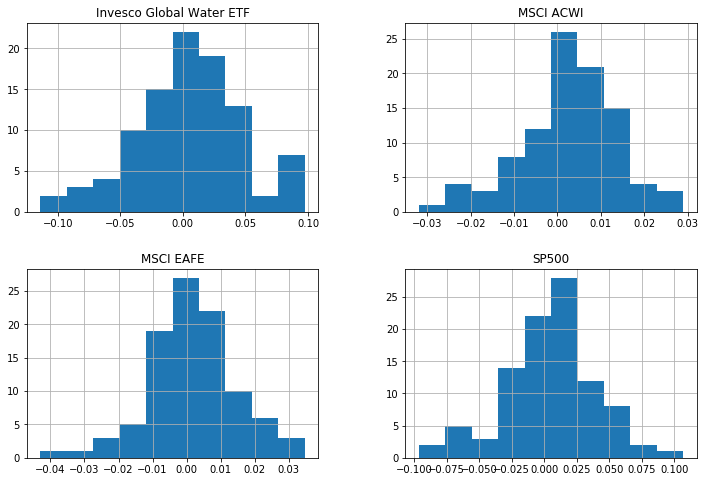

In [46]:
returns_data[lst].hist(figsize=(12,8))
plt.show()

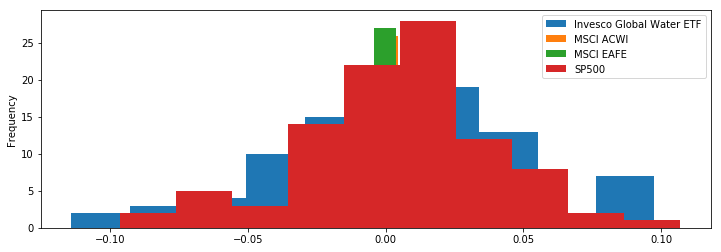

In [47]:
for i in lst:
    returns_data[i].plot(kind="hist",figsize=(12,4))
plt.legend(lst)
plt.show()

## Correlations

In [48]:
def render_scatter_plot(data, x_stock_name, y_stock_name, xlim=None, ylim=None):
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    #plot a scatter plot using the data[x] and data[y] coordinates
    ax.scatter(data[x_stock_name], data[y_stock_name])
    #If the x-axis limits are defined, then set them as such
    if xlim is not None: ax.set_xlim(xlim)
    ax.autoscale(False)
    #Vertical, horizontal and diagonal lines
    ax.vlines(0,-10,10)
    ax.hlines(0,-10,10)
    ax.plot((-10,10),(-10,10))
    #x and y labels
    ax.set_xlabel(x_stock_name)
    ax.set_ylabel(y_stock_name)

limits = [-0.15,0.15]

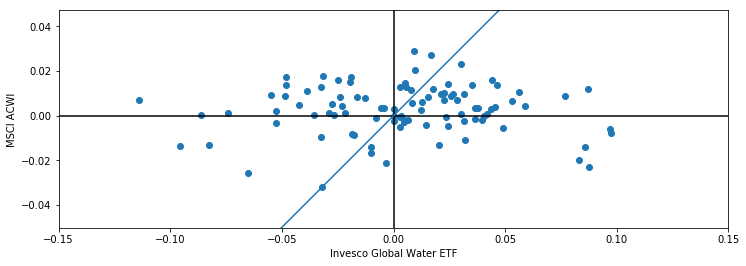

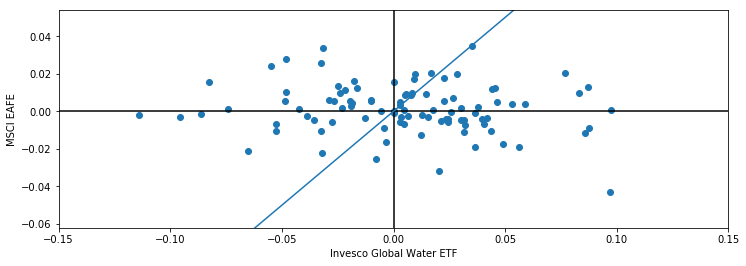

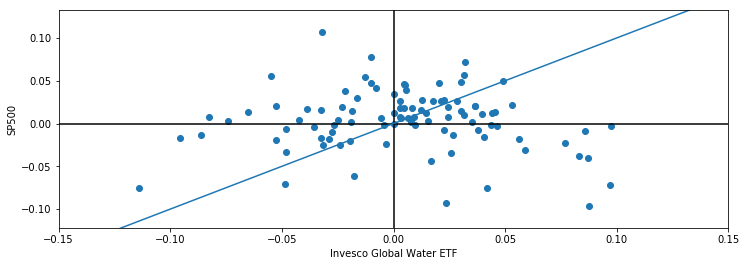

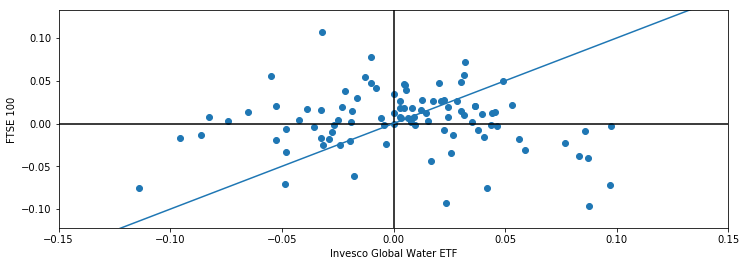

In [45]:
for i in lst:
    if i != fund:
        render_scatter_plot(returns_data,fund,i,xlim=limits)

# End